# SegFormer

## Install requirements

In [1]:
!pip install -q roboflow
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00


In [42]:
import os

import albumentations as A
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from roboflow import Roboflow
from sklearn.metrics import accuracy_score
from tabulate import tabulate
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

## Download dataset

In [3]:
rf = Roboflow(api_key="")
project = rf.workspace("semanticsegmentation-8o5vb").project("semanticsegmentation_dataset12052023")
dataset = project.version(17).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SemanticSegmentation_Dataset12052023-17 in png-mask-semantic:: 100%|██████████| 744/744 [00:00<00:00, 1965.44it/s]


## Replace data

In [4]:
%%shell

rm -rf /content/disaster_ds_raw
mkdir -p /content/checkpoints

for f in train valid test; do
    mkdir -p disaster_ds_raw/annotations/${f}
    mkdir -p disaster_ds_raw/images/${f}
done

for f in train valid test; do
    source_dir="/content/SemanticSegmentation_Dataset12052023-17/${f}"
    annotations_dir="/content/disaster_ds_raw/annotations/${f}"
    images_dir="/content/disaster_ds_raw/images/${f}"

    find "${source_dir}" -type f -name "*mask*" -exec mv {} "${annotations_dir}/" \;
    find "${source_dir}" -type f \( -name "*.jpg" -o -name "*.png" \) -not -name "*mask*" -exec mv {} "${images_dir}/" \;
done

rm -rf /content/SemanticSegmentation_Dataset12052023-17

source_dir="/content/disaster_ds_raw"
for p in annotations images; do

    for f in train valid test; do
        folder=${source_dir}/${p}/${f}
        count_files=$(find ${folder} -type f \( -name "*.jpg" -o -name "*.png" \) | wc -l)
        echo "in folder ${folder} there are ${count_files} images"
    done
done

in folder /content/disaster_ds_raw/annotations/train there are 273 images
in folder /content/disaster_ds_raw/annotations/valid there are 90 images
in folder /content/disaster_ds_raw/annotations/test there are 5 images
in folder /content/disaster_ds_raw/images/train there are 273 images
in folder /content/disaster_ds_raw/images/valid there are 90 images
in folder /content/disaster_ds_raw/images/test there are 5 images


## Train configs

In [45]:
cfg = {
    'dataset_root': '/content/disaster_ds_raw',
    'batch_size': 5,
    'num_epochs': 20,
    'lr': 0.00006,
    'model_type': 'nvidia/mit-b0',
    'checkpoint_load_path': False,
    'checkpoint_save_path': '/content/checkpoints/best_model',
}

In [46]:
cls_dict = {
    0: 'background',
    1: 'Damaged_buildings',
    2: 'Damaged_road',
    3: 'Damaged_vehicle',
    4: 'Debris',
    5: 'Fire',
    6: 'Flood',
    7: 'Injured_animal',
    8: 'Injured_person',
    9: 'Sky_background',
    10: 'Smoke',
    11: 'Trees',
    12: 'Uninjured_person'
}

## Augmentation setup

In [47]:
def get_transforms(mode='train'):

    if mode == 'train':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.4,
                rotate_limit=(-25, 25), border_mode=0,
                shift_limit_x=0.2,
                shift_limit_y=0.2),
            A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.5), contrast_limit=0.7, p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=(-10, 10),
                sat_shift_limit=(-180, 50),
                val_shift_limit=0,
                p=0.5),
            A.RandomToneCurve(p=0.2),
            A.ISONoise(p=0.1),
            A.OneOf([
                A.MedianBlur(blur_limit=5, p=0.5),
                A.GaussianBlur(blur_limit=5, p=0.5)
            ], p=0.1),
            A.ImageCompression(quality_lower=35, p=0.3),
            A.Perspective(scale=(0.05, 0.13), p=0.1),
            # A.RandomCrop(width=256, height=256, p=0.5),
            A.Cutout(num_holes=8, max_h_size=40, max_w_size=40, p=0.05),
            A.LongestMaxSize(max_size=512, p=1),
            A.PadIfNeeded(512, 512, border_mode=0, p=1),
        ],
            p=1.0)

    elif mode == 'val':
        return None

## Utility functions

In [48]:
def plot_result(img, seg, cls_dict):
    # Labels and classes names correspondance
    id2label = dict(cls_dict)
    label2id = {v: k for k, v in cls_dict.items()}

    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)  # height, width, 3
    palette = np.array(ade_palette())

    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Convert to BGR
    color_seg = color_seg[..., ::-1]

    img = np.array(img) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)

    legend_elements = [Patch(facecolor=(clr[::-1] / 255), label=cls_name) for [cls_name, clr] in zip(label2id.keys(), palette)]
    plt.legend(handles=legend_elements, loc="upper right")

    plt.show()


def save_checkpoint(cfg, best):
    save_path = f"{cfg['checkpoint_save_path']}_{cfg['model_type'].split('/')[-1]}_{best['epoch']}_{'%.4f' % best['loss']}.pt"
    torch.save({
        'epoch': best['epoch'],
        'model_state_dict': best['model_state_dict'],
        'optimizer_state_dict': best['optimizer_state_dict'],
        'loss': best['loss'],
        'val_iou_per_class': best['val_iou_per_class'],  # Save the validation IoU per class in the checkpoint
    }, save_path)


def load_checkpoint(cfg, model, optimizer):
    checkpoint = torch.load(cfg['checkpoint_load_path'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    val_iou_per_class = checkpoint['val_iou_per_class']

    print(f"Loaded checkpoint: {cfg['checkpoint_load_path']}")
    print(f"Start epoch: {start_epoch}")
    print(f"Loss: {loss}")

    return model, optimizer, start_epoch, loss, val_iou_per_class


def calculate_iou(pred, target, class_id):
    pred_mask = (pred == class_id)
    target_mask = (target == class_id)
    intersection = np.logical_and(pred_mask, target_mask).sum()
    union = np.logical_or(pred_mask, target_mask).sum()
    iou = 0.0 if union == 0 else intersection / union

    return iou  # Convert to a Python float


def ade_palette():
    """Custom palette that maps each class to RGB values."""
    return [
        [0, 0, 0],            # background (BLAK)
        [255, 0, 0],          # Damaged_buildings (BLUE)
        [0, 255, 0],          #
        [0, 0, 255],
        [255, 255, 0],
        [255, 0, 255],
        [0, 255, 255],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 128],
        [128, 128, 0],
        [0, 128, 128],
        [0, 0, 128],
    ]


def plot_loss(mode, pixelwise_accuracies, losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(pixelwise_accuracies) + 1), pixelwise_accuracies, label=f'{mode} Pixel-wise Accuracy')
    plt.plot(range(1, len(losses) + 1), losses, label=f'{mode} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'{mode} Pixel-wise Accuracy and Loss')
    plt.legend()
    plt.show()

## IoU accumulator

In [49]:
class IoUTable:

    def __init__(self, cfg, cls_dict):
        self.cfg = cfg
        self.cumulative_iou_table_data = []
        self.id2label = dict(cls_dict)
        self.label2id = {v: k for k, v in cls_dict.items()}
        self.cumulative_iou_values_per_class = {class_name: 0.0 for class_name in self.id2label.values()}
        self.val_iou_per_class_epoch = {class_name: [] for class_name in self.id2label.values()}

    def get_val_iou_per_class_epoch(self, predicted, labels):

        for class_id, class_name in enumerate(self.id2label.values()):
            class_iou = calculate_iou(predicted.cpu(), labels.cpu(), class_id)
            self.val_iou_per_class_epoch[class_name].append(class_iou)

    def update_data(self):
        print("Validation IoU per class:")

        self.iou_table_data = []

        for class_name in self.id2label.values():  # Update variable name here
            # Calculate the average IoU for the current epoch
            average_iou = np.mean(self.val_iou_per_class_epoch[class_name])

            # Add the current epoch's IoU to the cumulative IoU for this class
            self.cumulative_iou_values_per_class[class_name] += average_iou

            self.iou_table_data.append([class_name, average_iou])

        print(tabulate(self.iou_table_data, headers=["Class", "IoU per class"], tablefmt="grid"))

        self.val_iou_per_class_epoch = {class_name: [] for class_name in self.id2label.values()}

    def print_cumulative_iou(self):
        print("\nCumulative IoU per class:")

        for class_name, cumulative_iou in self.cumulative_iou_values_per_class.items():
            # Divide the cumulative IoU by the divisor
            cumulative_iou /= self.cfg['num_epochs']
            self.cumulative_iou_table_data.append([class_name, cumulative_iou])

        print(tabulate(self.cumulative_iou_table_data, headers=["Class", "Mean IoU by class"], tablefmt="grid"))

## Dataset class

In [50]:
class SegFormerDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True, transforms=None):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "valid"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []

        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)

        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []

        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)

        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        if self.transforms:
            data = self.transforms(image=np.array(image), mask=np.array(segmentation_map))
            # randomly crop + pad both image and segmentation map to same size
            encoded_inputs = self.feature_extractor(data['image'], data['mask'], return_tensors="pt")

        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()  # remove batch dimension

        return encoded_inputs

## Train

In [51]:
def train(cfg, cls_dict):
    # Labels and classes names correspondance
    id2label = dict(cls_dict)
    label2id = {v: k for k, v in cls_dict.items()}

    feature_extractor = SegformerImageProcessor(reduce_zero_labels=True)  # get feature extractor of SegFormer

    # Set transforms (augmentations)
    train_transforms = get_transforms(mode='train')
    val_transforms = None

    # Get datasets
    train_dataset = SegFormerDataset(
        root_dir=cfg['dataset_root'],
        feature_extractor=feature_extractor,
        train=True,
        transforms=train_transforms,
    )
    valid_dataset = SegFormerDataset(
        root_dir=cfg['dataset_root'],
        feature_extractor=feature_extractor,
        train=False,
        transforms=val_transforms,
    )

    # Get dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=cfg['batch_size'])

    # Get the model
    model = SegformerForSemanticSegmentation.from_pretrained(
        cfg['model_type'],
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id,
    )

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])

    # Load checkpoint if necessary
    if cfg['checkpoint_load_path']:
        model, optimizer, start_epoch, loss, val_iou_per_class = load_checkpoint(cfg, model, optimizer)

    else:
        start_epoch = 1

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # initialize available device
    model.to(device)  # send model to device

    # Losses placeholders
    train_losses = []
    val_losses = []

    # Pixelwise accs placeholders
    train_pixelwise_accuracies = []
    val_pixelwise_accuracies = []

    # Initialize the list to store IoU values for each class in the validation set
    val_iou_per_class = []

    # # Initialize a variable to keep track of the best training pixel-wise accuracy
    val_pixelwise_accuracies_epoch = []
    val_losses_epoch = []

    # Best values placeholder
    best = dict()
    best['val_pixelwise_accuracy'] = 0.0  # Initialize the best validation pixel-wise accuracy
    best['model_state_dict'] = None  # Initialize the state_dict of the best model

    # IoU table data accumulation
    iou_table = IoUTable(cfg, cls_dict)

    # Iterate through epochs
    for epoch in range(start_epoch, cfg['num_epochs'] + 1):
        print("Epoch:", epoch)
        pbar = tqdm(
            train_dataloader,
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]",
            colour='green'
        )

        # Epoch placeholders
        accuracies = []
        val_accuracies = []
        losses = []
        val_losses = []

        model.train()

        for idx, batch in enumerate(pbar):
            # Get the inputs
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(pixel_values=pixel_values, labels=labels)

            # Evaluate
            upsampled_logits = torch.nn.functional.interpolate(
                outputs.logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            predicted = upsampled_logits.argmax(dim=1)

            mask = (labels != 255)  # we don't include the background class in the accuracy calculation
            pred_labels = predicted[mask].detach().cpu().numpy()
            true_labels = labels[mask].detach().cpu().numpy()
            accuracy = accuracy_score(pred_labels, true_labels)
            loss = outputs.loss
            accuracies.append(accuracy)
            losses.append(loss.item())
            pbar.set_postfix({'Pixel-wise accuracy': sum(accuracies) / len(accuracies), 'Loss': sum(losses) / len(losses)})

            # Backward + optimize
            loss.backward()
            optimizer.step()

        else:
            model.eval()

            with torch.no_grad():

                for idx, batch in enumerate(valid_dataloader):
                    pixel_values = batch["pixel_values"].to(device)
                    labels = batch["labels"].to(device)

                    outputs = model(pixel_values=pixel_values, labels=labels)
                    upsampled_logits = torch.nn.functional.interpolate(
                        outputs.logits,
                        size=labels.shape[-2:],
                        mode="bilinear",
                        align_corners=False
                    )
                    predicted = upsampled_logits.argmax(dim=1)

                    mask = (labels != 255)  # we don't include the background class in the accuracy calculation
                    pred_labels = predicted[mask].cpu().detach().numpy()
                    true_labels = labels[mask].cpu().detach().numpy()
                    accuracy = accuracy_score(pred_labels, true_labels)
                    val_loss = outputs.loss
                    val_accuracies.append(accuracy)
                    val_losses.append(val_loss.item())

                    # Calculate the IoU for each class
                    iou_table.get_val_iou_per_class_epoch(predicted, labels)

        train_accuracy = sum(accuracies) / len(accuracies)
        train_loss = sum(losses) / len(losses)
        val_accuracy = sum(val_accuracies) / len(val_accuracies)
        val_loss = sum(val_losses) / len(val_losses)

        train_pixelwise_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        val_pixelwise_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        val_pixelwise_accuracies_epoch.append(val_accuracy)
        val_losses_epoch.append(val_loss)

        print(
            f"Train Pixel-wise accuracy: {sum(accuracies) / len(accuracies)} \
            Train Loss: {sum(losses) / len(losses)} \
            Val Pixel-wise accuracy: {sum(val_accuracies) / len(val_accuracies)} \
            Val Loss: {sum(val_losses) / len(val_losses)}"
        )

        # Display the table using tabulate
        iou_table.update_data()

        if val_accuracy > best['val_pixelwise_accuracy']:
            best['val_pixelwise_accuracy'] = val_accuracy
            best['model_state_dict'] = model.state_dict()
            best['optimizer_state_dict'] = optimizer.state_dict()
            best['loss'] = loss
            best['val_iou_per_class'] = val_iou_per_class
            best['epoch'] = epoch

    # Save the best checkpoint after all epochs have completed
    if best['model_state_dict']:
        save_checkpoint(cfg, best)

    # Calculate the cumulative IoU values using the accumulated values
    iou_table.print_cumulative_iou()

    # Plotting training pixel-wise accuracies and losses
    plot_loss('Train', train_pixelwise_accuracies, train_losses)
    plot_loss('Validation', val_pixelwise_accuracies_epoch, val_losses_epoch)

blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
Cutout has been deprecated. Please use CoarseDropout
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1


100%|██████████| 55/55 [00:28<00:00,  1.91it/s, Pixel-wise accuracy=0.588, Loss=1.79]


Train Pixel-wise accuracy: 0.5879650878906248             Train Loss: 1.7917053200981834             Val Pixel-wise accuracy: 0.5455337948269314             Val Loss: 1.745528413189782
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |      0.0622645  |
+-------------------+-----------------+
| Damaged_buildings |      0.171697   |
+-------------------+-----------------+
| Damaged_road      |      0.0520195  |
+-------------------+-----------------+
| Damaged_vehicle   |      0.00131566 |
+-------------------+-----------------+
| Debris            |      0.289466   |
+-------------------+-----------------+
| Fire              |      0.0661012  |
+-------------------+-----------------+
| Flood             |      0.170611   |
+-------------------+-----------------+
| Injured_animal    |      0          |
+-------------------+-----------------+
| Injured_person    |      0.

100%|██████████| 55/55 [00:30<00:00,  1.78it/s, Pixel-wise accuracy=0.703, Loss=1.28]


Train Pixel-wise accuracy: 0.7026352622292257             Train Loss: 1.2794896472584119             Val Pixel-wise accuracy: 0.6266009436713325             Val Loss: 1.3830051753256056
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |      0.0404216  |
+-------------------+-----------------+
| Damaged_buildings |      0.322652   |
+-------------------+-----------------+
| Damaged_road      |      0.200667   |
+-------------------+-----------------+
| Damaged_vehicle   |      0.0053703  |
+-------------------+-----------------+
| Debris            |      0.326684   |
+-------------------+-----------------+
| Fire              |      0.0725669  |
+-------------------+-----------------+
| Flood             |      0.198976   |
+-------------------+-----------------+
| Injured_animal    |      0          |
+-------------------+-----------------+
| Injured_person    |      0

100%|██████████| 55/55 [00:28<00:00,  1.94it/s, Pixel-wise accuracy=0.737, Loss=1.09]


Train Pixel-wise accuracy: 0.7366757294625949             Train Loss: 1.0887013749642807             Val Pixel-wise accuracy: 0.681922403971354             Val Loss: 1.2192592786418068
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0412147 |
+-------------------+-----------------+
| Damaged_buildings |       0.363485  |
+-------------------+-----------------+
| Damaged_road      |       0.278728  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.0325042 |
+-------------------+-----------------+
| Debris            |       0.343631  |
+-------------------+-----------------+
| Fire              |       0.0788687 |
+-------------------+-----------------+
| Flood             |       0.18152   |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       0

100%|██████████| 55/55 [00:28<00:00,  1.94it/s, Pixel-wise accuracy=0.771, Loss=0.947]


Train Pixel-wise accuracy: 0.7707113416267164             Train Loss: 0.9469470685178584             Val Pixel-wise accuracy: 0.7107870737711588             Val Loss: 1.0766305492983925
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.042589  |
+-------------------+-----------------+
| Damaged_buildings |       0.353828  |
+-------------------+-----------------+
| Damaged_road      |       0.321266  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.0748369 |
+-------------------+-----------------+
| Debris            |       0.35474   |
+-------------------+-----------------+
| Fire              |       0.095325  |
+-------------------+-----------------+
| Flood             |       0.216548  |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       

100%|██████████| 55/55 [00:27<00:00,  2.00it/s, Pixel-wise accuracy=0.789, Loss=0.855]


Train Pixel-wise accuracy: 0.7894963351162997             Train Loss: 0.8547615007920699             Val Pixel-wise accuracy: 0.7395050896538627             Val Loss: 0.9674901399347519
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |     0.0424079   |
+-------------------+-----------------+
| Damaged_buildings |     0.370425    |
+-------------------+-----------------+
| Damaged_road      |     0.340548    |
+-------------------+-----------------+
| Damaged_vehicle   |     0.182485    |
+-------------------+-----------------+
| Debris            |     0.372719    |
+-------------------+-----------------+
| Fire              |     0.100601    |
+-------------------+-----------------+
| Flood             |     0.232303    |
+-------------------+-----------------+
| Injured_animal    |     0           |
+-------------------+-----------------+
| Injured_person    |     0.

100%|██████████| 55/55 [00:26<00:00,  2.06it/s, Pixel-wise accuracy=0.788, Loss=0.825]


Train Pixel-wise accuracy: 0.7880549020478219             Train Loss: 0.8246233116496693             Val Pixel-wise accuracy: 0.7558831956651477             Val Loss: 0.9196969767411549
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |     0.0616272   |
+-------------------+-----------------+
| Damaged_buildings |     0.371226    |
+-------------------+-----------------+
| Damaged_road      |     0.33972     |
+-------------------+-----------------+
| Damaged_vehicle   |     0.209949    |
+-------------------+-----------------+
| Debris            |     0.354573    |
+-------------------+-----------------+
| Fire              |     0.103554    |
+-------------------+-----------------+
| Flood             |     0.24791     |
+-------------------+-----------------+
| Injured_animal    |     0           |
+-------------------+-----------------+
| Injured_person    |     0.

100%|██████████| 55/55 [00:27<00:00,  1.97it/s, Pixel-wise accuracy=0.815, Loss=0.752]


Train Pixel-wise accuracy: 0.8151296257250236             Train Loss: 0.7516591993245212             Val Pixel-wise accuracy: 0.7441993713378907             Val Loss: 0.894838985469606
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |      0.0659828  |
+-------------------+-----------------+
| Damaged_buildings |      0.377794   |
+-------------------+-----------------+
| Damaged_road      |      0.35508    |
+-------------------+-----------------+
| Damaged_vehicle   |      0.252472   |
+-------------------+-----------------+
| Debris            |      0.385926   |
+-------------------+-----------------+
| Fire              |      0.088199   |
+-------------------+-----------------+
| Flood             |      0.235166   |
+-------------------+-----------------+
| Injured_animal    |      0          |
+-------------------+-----------------+
| Injured_person    |      0.

100%|██████████| 55/55 [00:29<00:00,  1.87it/s, Pixel-wise accuracy=0.811, Loss=0.719]


Train Pixel-wise accuracy: 0.8106752569025213             Train Loss: 0.7191723021593961             Val Pixel-wise accuracy: 0.7371906704372829             Val Loss: 0.9206471062368816
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |      0.0430925  |
+-------------------+-----------------+
| Damaged_buildings |      0.368159   |
+-------------------+-----------------+
| Damaged_road      |      0.338258   |
+-------------------+-----------------+
| Damaged_vehicle   |      0.264283   |
+-------------------+-----------------+
| Debris            |      0.36944    |
+-------------------+-----------------+
| Fire              |      0.0972089  |
+-------------------+-----------------+
| Flood             |      0.235335   |
+-------------------+-----------------+
| Injured_animal    |      0          |
+-------------------+-----------------+
| Injured_person    |      0

100%|██████████| 55/55 [00:26<00:00,  2.04it/s, Pixel-wise accuracy=0.824, Loss=0.673]


Train Pixel-wise accuracy: 0.8243330522017045             Train Loss: 0.6730160415172577             Val Pixel-wise accuracy: 0.751956091986762             Val Loss: 0.8446166846487259
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |      0.0434897  |
+-------------------+-----------------+
| Damaged_buildings |      0.381705   |
+-------------------+-----------------+
| Damaged_road      |      0.362368   |
+-------------------+-----------------+
| Damaged_vehicle   |      0.299496   |
+-------------------+-----------------+
| Debris            |      0.390517   |
+-------------------+-----------------+
| Fire              |      0.0926119  |
+-------------------+-----------------+
| Flood             |      0.214972   |
+-------------------+-----------------+
| Injured_animal    |      0          |
+-------------------+-----------------+
| Injured_person    |      0.

100%|██████████| 55/55 [00:27<00:00,  2.03it/s, Pixel-wise accuracy=0.836, Loss=0.619]


Train Pixel-wise accuracy: 0.8359481950239702             Train Loss: 0.6185092741792853             Val Pixel-wise accuracy: 0.7495969136555989             Val Loss: 0.846242118212912
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |      0.0431408  |
+-------------------+-----------------+
| Damaged_buildings |      0.367437   |
+-------------------+-----------------+
| Damaged_road      |      0.348847   |
+-------------------+-----------------+
| Damaged_vehicle   |      0.280904   |
+-------------------+-----------------+
| Debris            |      0.366663   |
+-------------------+-----------------+
| Fire              |      0.0930379  |
+-------------------+-----------------+
| Flood             |      0.236409   |
+-------------------+-----------------+
| Injured_animal    |      0          |
+-------------------+-----------------+
| Injured_person    |      0.

100%|██████████| 55/55 [00:28<00:00,  1.96it/s, Pixel-wise accuracy=0.83, Loss=0.614]


Train Pixel-wise accuracy: 0.8300277478767165             Train Loss: 0.614397036487406             Val Pixel-wise accuracy: 0.7724319034152561             Val Loss: 0.775667957133717
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0425209 |
+-------------------+-----------------+
| Damaged_buildings |       0.391135  |
+-------------------+-----------------+
| Damaged_road      |       0.3626    |
+-------------------+-----------------+
| Damaged_vehicle   |       0.289163  |
+-------------------+-----------------+
| Debris            |       0.411577  |
+-------------------+-----------------+
| Fire              |       0.0984735 |
+-------------------+-----------------+
| Flood             |       0.22988   |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       0.

100%|██████████| 55/55 [00:26<00:00,  2.10it/s, Pixel-wise accuracy=0.838, Loss=0.584]


Train Pixel-wise accuracy: 0.8376097754276159             Train Loss: 0.583668790622191             Val Pixel-wise accuracy: 0.7511985354953342             Val Loss: 0.8014706555340025
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0444154 |
+-------------------+-----------------+
| Damaged_buildings |       0.394317  |
+-------------------+-----------------+
| Damaged_road      |       0.358059  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.301634  |
+-------------------+-----------------+
| Debris            |       0.388655  |
+-------------------+-----------------+
| Fire              |       0.0944699 |
+-------------------+-----------------+
| Flood             |       0.209116  |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       0

100%|██████████| 55/55 [00:28<00:00,  1.93it/s, Pixel-wise accuracy=0.841, Loss=0.565]


Train Pixel-wise accuracy: 0.841002382220644             Train Loss: 0.5647834561087869             Val Pixel-wise accuracy: 0.7760228051079645             Val Loss: 0.7514162212610245
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0462928 |
+-------------------+-----------------+
| Damaged_buildings |       0.406021  |
+-------------------+-----------------+
| Damaged_road      |       0.361778  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.286397  |
+-------------------+-----------------+
| Debris            |       0.402821  |
+-------------------+-----------------+
| Fire              |       0.0970885 |
+-------------------+-----------------+
| Flood             |       0.230572  |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       0

100%|██████████| 55/55 [00:33<00:00,  1.64it/s, Pixel-wise accuracy=0.854, Loss=0.522]


Train Pixel-wise accuracy: 0.8539104438550548             Train Loss: 0.5220116046341983             Val Pixel-wise accuracy: 0.7749653710259331             Val Loss: 0.7554673171705669
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0435626 |
+-------------------+-----------------+
| Damaged_buildings |       0.406194  |
+-------------------+-----------------+
| Damaged_road      |       0.36673   |
+-------------------+-----------------+
| Damaged_vehicle   |       0.292333  |
+-------------------+-----------------+
| Debris            |       0.389765  |
+-------------------+-----------------+
| Fire              |       0.0937066 |
+-------------------+-----------------+
| Flood             |       0.214559  |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       

100%|██████████| 55/55 [00:29<00:00,  1.84it/s, Pixel-wise accuracy=0.857, Loss=0.504]


Train Pixel-wise accuracy: 0.8569328539299241             Train Loss: 0.5036700590090318             Val Pixel-wise accuracy: 0.7867362128363715             Val Loss: 0.7274775670634376
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0428659 |
+-------------------+-----------------+
| Damaged_buildings |       0.394693  |
+-------------------+-----------------+
| Damaged_road      |       0.372619  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.293905  |
+-------------------+-----------------+
| Debris            |       0.413762  |
+-------------------+-----------------+
| Fire              |       0.0946199 |
+-------------------+-----------------+
| Flood             |       0.243663  |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       

100%|██████████| 55/55 [00:28<00:00,  1.94it/s, Pixel-wise accuracy=0.86, Loss=0.501]


Train Pixel-wise accuracy: 0.8595774471398557             Train Loss: 0.5008322092619809             Val Pixel-wise accuracy: 0.7694465213351779             Val Loss: 0.767555832862854
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0453774 |
+-------------------+-----------------+
| Damaged_buildings |       0.410915  |
+-------------------+-----------------+
| Damaged_road      |       0.332277  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.274865  |
+-------------------+-----------------+
| Debris            |       0.32408   |
+-------------------+-----------------+
| Fire              |       0.0953026 |
+-------------------+-----------------+
| Flood             |       0.2198    |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       0

100%|██████████| 55/55 [00:28<00:00,  1.94it/s, Pixel-wise accuracy=0.858, Loss=0.496]


Train Pixel-wise accuracy: 0.8575168863932291             Train Loss: 0.4964552846821872             Val Pixel-wise accuracy: 0.7754488203260633             Val Loss: 0.7584657238589393
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0438736 |
+-------------------+-----------------+
| Damaged_buildings |       0.350222  |
+-------------------+-----------------+
| Damaged_road      |       0.347462  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.283648  |
+-------------------+-----------------+
| Debris            |       0.418624  |
+-------------------+-----------------+
| Fire              |       0.0938839 |
+-------------------+-----------------+
| Flood             |       0.200762  |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       

100%|██████████| 55/55 [00:27<00:00,  2.01it/s, Pixel-wise accuracy=0.859, Loss=0.498]


Train Pixel-wise accuracy: 0.858763830011541             Train Loss: 0.4978748467835513             Val Pixel-wise accuracy: 0.7723167843288846             Val Loss: 0.7734716501500871
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0486597 |
+-------------------+-----------------+
| Damaged_buildings |       0.390844  |
+-------------------+-----------------+
| Damaged_road      |       0.367994  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.294204  |
+-------------------+-----------------+
| Debris            |       0.411744  |
+-------------------+-----------------+
| Fire              |       0.0936345 |
+-------------------+-----------------+
| Flood             |       0.201694  |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       0

100%|██████████| 55/55 [00:29<00:00,  1.88it/s, Pixel-wise accuracy=0.867, Loss=0.465]


Train Pixel-wise accuracy: 0.8665997684363165             Train Loss: 0.4654245235703208             Val Pixel-wise accuracy: 0.7916801876491971             Val Loss: 0.70501509308815
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0458339 |
+-------------------+-----------------+
| Damaged_buildings |       0.412152  |
+-------------------+-----------------+
| Damaged_road      |       0.369496  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.320062  |
+-------------------+-----------------+
| Debris            |       0.434377  |
+-------------------+-----------------+
| Fire              |       0.0915783 |
+-------------------+-----------------+
| Flood             |       0.216043  |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       0.

100%|██████████| 55/55 [00:29<00:00,  1.88it/s, Pixel-wise accuracy=0.86, Loss=0.485]


Train Pixel-wise accuracy: 0.8604933443936439             Train Loss: 0.4851543925025246             Val Pixel-wise accuracy: 0.792709435356988             Val Loss: 0.7051669665508801
Validation IoU per class:
+-------------------+-----------------+
| Class             |   IoU per class |
+===================+=================+
| background        |       0.0464001 |
+-------------------+-----------------+
| Damaged_buildings |       0.416216  |
+-------------------+-----------------+
| Damaged_road      |       0.375712  |
+-------------------+-----------------+
| Damaged_vehicle   |       0.300957  |
+-------------------+-----------------+
| Debris            |       0.409376  |
+-------------------+-----------------+
| Fire              |       0.082295  |
+-------------------+-----------------+
| Flood             |       0.207622  |
+-------------------+-----------------+
| Injured_animal    |       0         |
+-------------------+-----------------+
| Injured_person    |       0

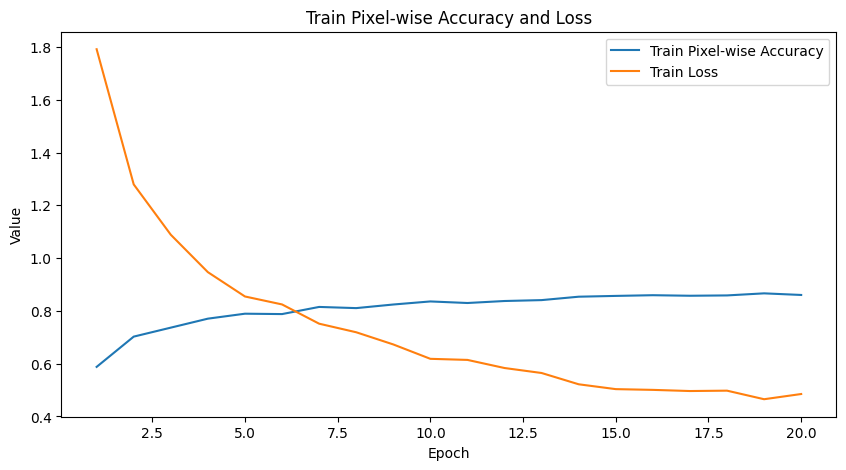

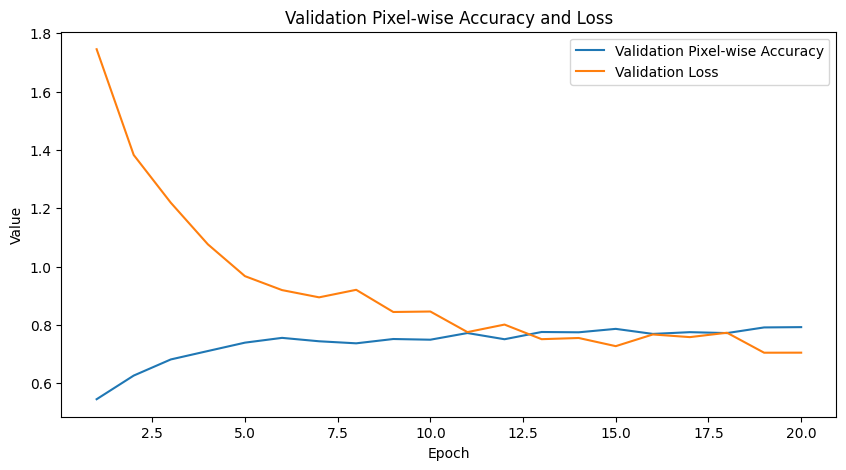

In [52]:
# Run training
train(cfg=cfg, cls_dict=cls_dict)

## Inference
* Please input your data in infer_cfg (the cell below)

In [31]:
infer_cfg = {
    'dataset_root': './disaster_ds_raw',
    'model_type': 'nvidia/mit-b4',
    'checkpoint_load_path': '/content/drive/MyDrive/dvc/segformer/best_model_mit-b4_28_0.2617.pt',
    'input_path': '/content/test_images/test00001.png',
}

In [38]:
# Labels and classes names correspondance
id2label = dict(cls_dict)
label2id = {v: k for k, v in cls_dict.items()}

In [39]:
feature_extractor = SegformerImageProcessor(do_reduce_labels=False)
model = SegformerForSemanticSegmentation.from_pretrained(
    infer_cfg['model_type'],
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.classifier.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.num_batches_tracked']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint = torch.load(infer_cfg['checkpoint_load_path'])
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # initialize available device
model.to(device)  # send model to device

In [43]:
img = Image.fromarray(np.array(Image.open(infer_cfg['input_path'])))

encoding = feature_extractor(img, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
outputs = model(pixel_values=pixel_values)
pred_masks = outputs.logits
logits = outputs.logits.cpu()
upsampled_logits = nn.functional.interpolate(logits,
                size=img.size[::-1],  # (height, width)
                mode='bilinear',
                align_corners=False)
upsampled_logits = torch.sigmoid(upsampled_logits)
seg = upsampled_logits.argmax(dim=1)[0]

## Plot results

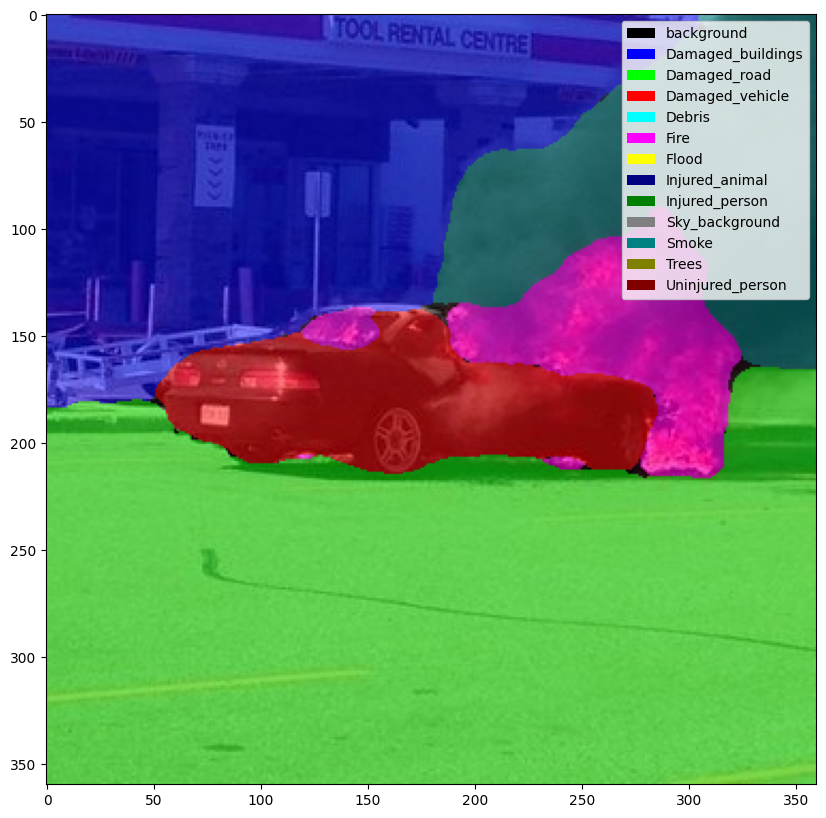

In [44]:
# Plot result
plot_result(img, seg, cls_dict)